<a href="https://colab.research.google.com/github/elhamsh93/segmentation/blob/main/road_unet11_original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

### In this notebook we use UNet for Road Extraction from Satellite Imagery using [DeepGlobe Road Extraction Dataset](https://www.kaggle.com/balraj98/deepglobe-road-extraction-dataset).

### Libraries 📚⬇

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [ ]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null

In [ ]:
# !pip install kaggle

In [ ]:
# !mkdir -p ~/.kaggle
# !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# !kaggle datasets download -d balraj98/deepglobe-road-extraction-dataset -p /content/drive/MyDrive/deepglobe-road-extraction-dataset --force

In [ ]:
# !unzip /content/drive/MyDrive/deepglobe-road-extraction-dataset/deepglobe-road-extraction-dataset.zip -d /content/drive/MyDrive/deepglobe-road-extraction-dataset

### Read Data & Create train / valid splits 📁

In [ ]:
!cp -r /content/drive/MyDrive/segmentation_models.pytorch /content/

In [ ]:
%cd /content/segmentation_models.pytorch

/content/segmentation_models.pytorch


In [ ]:
!pip install -r requirements.txt

In [ ]:
!cp -r /content/segmentation_models.pytorch/segmentation_models_pytorch /content/

In [ ]:
%cd /content/segmentation_models.pytorch/segmentation_models_pytorch

/content/segmentation_models.pytorch/segmentation_models_pytorch


In [ ]:
import segmentation_models_pytorch as smp

In [ ]:
DATA_DIR = '/content/drive/MyDrive/deepglobe-road-extraction-dataset'

metadata_df = pd.read_csv(os.path.join(DATA_DIR, 'metadata.csv'))
metadata_df = metadata_df[metadata_df['split']=='train']
metadata_df = metadata_df[['image_id', 'sat_image_path', 'mask_path']]
metadata_df['sat_image_path'] = metadata_df['sat_image_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
metadata_df['mask_path'] = metadata_df['mask_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
# Shuffle DataFrame
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
num_images = 3000

# Select a random subset of images
indices = torch.randperm(len(metadata_df))[:num_images]
subset_df = metadata_df.iloc[indices]

# Perform 80/10 split for train / val
valid_df = subset_df.sample(frac=0.2, random_state=42)
train_df = subset_df.drop(valid_df.index)
len(train_df), len(valid_df)

(2400, 600)

In [ ]:
class_dict = pd.read_csv(os.path.join(DATA_DIR, 'class_dict.csv'))
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['road', 'background']
Class RGB values:  [[255, 255, 255], [0, 0, 0]]


#### Shortlist specific classes to segment

In [ ]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['background', 'road']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['road', 'background']
Class RGB values:  [[255, 255, 255], [0, 0, 0]]


### Helper functions for viz. & one-hot encoding/decoding

In [ ]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]);
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [ ]:
test_images = ['/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/223900_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/554086_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/716527_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/20949_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/237387_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/576981_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/590465_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/528828_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/491932_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/697216_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/303200_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/400501_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/608001_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/209322_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/953595_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/113050_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/613155_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/731150_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/207837_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/129205_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/445545_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/42511_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/142373_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/650720_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/974773_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/825009_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/22174_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/97115_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/462368_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/497407_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/563528_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/121763_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/942837_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/374575_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/500322_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/50782_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/462257_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/168486_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/93824_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/624435_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/953228_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/297975_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/154811_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/25415_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/656960_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/404694_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/364453_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/853055_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/108254_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/687265_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/204654_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/231652_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/195106_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/384422_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/785735_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/622953_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/957715_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/569991_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/261721_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/237922_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/348118_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/625445_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/711758_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/48710_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/734244_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/969001_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/955948_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/851977_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/258318_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/229907_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/374374_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/574395_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/471960_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/987840_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/857169_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/114285_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/603884_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/409191_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/141378_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/373615_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/434374_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/828247_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/600754_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/846979_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/449967_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/861243_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/748601_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/795676_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/616672_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/875559_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/371353_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/725392_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/194423_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/122885_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/314575_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/688218_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/607575_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/88650_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/710935_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/860220_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/953074_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/779760_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/212985_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/300246_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/341469_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/480527_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/364140_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/343286_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/16493_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/344627_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/875701_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/191470_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/773440_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/470078_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/654556_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/60445_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/696096_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/649332_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/929716_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/229952_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/278507_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/581725_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/22856_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/134151_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/70312_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/183675_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/592455_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/538837_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/957367_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/434498_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/865256_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/398701_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/429455_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/842844_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/318586_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/158968_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/358199_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/589420_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/815168_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/825095_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/227689_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/147586_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/694729_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/692502_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/938344_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/883059_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/203508_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/319391_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/769376_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/197549_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/304805_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/867062_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/212245_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/63238_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/578480_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/934232_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/483392_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/577027_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/127647_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/669564_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/666658_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/563695_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/887028_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/723436_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/353070_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/322697_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/622328_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/331266_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/843628_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/964566_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/999248_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/131782_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/606228_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/354691_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/287766_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/883595_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/945265_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/54635_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/57645_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/8840_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/625448_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/105553_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/97321_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/195501_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/370418_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/429404_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/976970_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/266585_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/48730_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/638717_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/489779_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/412858_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/6281_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/244489_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/833628_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/8980_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/994957_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/730531_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/3594_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/100892_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/558585_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/718185_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/819858_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/57809_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/860513_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/181193_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/592427_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/865868_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/228240_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/400867_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/645554_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/669038_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/248997_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/941665_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/152132_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/670062_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/538197_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/402430_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/642260_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/802821_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/27127_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/854216_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/158426_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/298428_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/822425_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/292761_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/39694_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/491350_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/524879_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/298975_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/868778_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/413810_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/769104_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/882937_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/188924_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/873424_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/635475_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/472410_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/577208_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/363388_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/640816_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/866093_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/470708_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/298555_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/253169_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/631198_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/216610_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/700753_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/932396_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/153265_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/860545_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/68022_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/435505_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/246363_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/839673_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/730185_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/893987_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/848854_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/360368_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/954744_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/707576_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/829335_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/9433_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/168242_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/913696_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/289860_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/79234_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/856074_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/417078_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/457865_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/322316_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/51634_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/232140_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/430950_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/946567_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/764473_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/735003_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/444795_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/643427_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/86805_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/917198_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/400649_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/813939_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/462844_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/260008_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/718920_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/511798_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/238546_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/393469_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/750485_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/405292_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/974158_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/959705_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/154786_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/937572_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/26566_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/351358_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/113252_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/582585_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/899152_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/887947_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/714780_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/733133_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/692921_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/251044_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/754467_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/201885_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/606850_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/401257_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/551684_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/499882_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/649408_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/636014_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/7372_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/856890_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/795582_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/363400_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/894555_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/686449_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/169837_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/935147_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/617648_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/124192_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/307216_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/343_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/329892_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/724095_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/362406_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/297896_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/197397_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/262506_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/236489_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/395487_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/723117_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/553521_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/8971_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/729020_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/357382_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/808719_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/987408_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/193878_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/545721_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/860454_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/40820_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/727513_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/998098_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/665540_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/779588_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/723970_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/750897_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/201964_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/153937_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/357219_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/732079_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/969112_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/235133_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/75815_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/9339_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/95573_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/735075_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/644027_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/749641_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/238582_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/106737_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/572867_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/532685_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/369819_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/391538_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/766257_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/450934_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/425305_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/504545_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/148138_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/40699_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/2262_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/505418_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/692067_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/706206_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/974843_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/787694_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/483576_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/297846_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/827391_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/330017_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/736761_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/435877_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/286522_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/886896_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/272786_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/246789_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/866513_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/156551_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/707088_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/536197_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/765293_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/163215_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/600175_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/337461_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/222724_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/98225_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/95571_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/220961_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/839979_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/137772_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/665514_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/421746_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/652155_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/993512_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/160894_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/831156_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/585172_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/366622_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/384296_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/57632_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/755736_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/501593_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/176841_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/580468_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/938699_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/5386_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/343801_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/514669_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/723042_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/648470_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/174757_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/274946_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/911456_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/929046_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/996111_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/585197_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/897784_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/675430_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/866782_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/342201_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/574652_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/174568_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/178776_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/316904_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/927396_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/816459_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/960291_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/639198_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/842246_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/826412_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/909613_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/77698_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/42359_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/56652_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/767677_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/794377_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/350071_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/721436_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/536023_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/912380_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/367591_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/734621_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/925525_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/11168_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/60217_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/624745_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/453682_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/157037_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/530257_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/375428_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/981956_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/486292_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/528213_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/455244_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/434853_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/410490_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/866827_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/59116_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/806696_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/232317_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/992526_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/832501_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/441863_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/999531_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/928916_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/597361_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/99665_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/56371_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/421882_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/533738_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/984438_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/471129_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/767496_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/567954_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/680928_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/771504_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/140314_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/141532_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/917966_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/306632_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/276572_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/946808_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/996898_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/841608_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/834703_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/328712_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/906649_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/225487_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/972206_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/822197_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/676161_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/558593_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/928771_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/63098_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/179541_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/785180_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/935105_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/771601_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/248426_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/621540_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/788177_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/893442_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/106523_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/758682_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/476415_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/434989_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/48682_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/654250_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/400877_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/447816_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/64979_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/761119_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/923367_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/205591_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/21449_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/661786_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/461832_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/242466_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/892762_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/818225_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/964926_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/829413_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/576096_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/118005_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/227114_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/373103_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/292384_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/547154_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/939927_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/105742_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/604560_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/609667_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/746839_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/994121_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/226279_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/582163_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/753390_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/374383_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/225869_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/540725_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/389555_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/644503_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/934673_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/519597_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/532269_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/747392_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/84601_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/111475_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/949143_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/239555_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/370328_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/116231_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/960162_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/556106_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/845865_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/331675_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/818569_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/68616_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/414592_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/430332_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/738906_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/428625_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/662246_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/455462_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/127271_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/234448_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/165674_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/200332_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/369061_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/81946_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/444164_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/31268_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/285170_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/427696_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/357961_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/90063_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/182133_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/632287_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/415694_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/961336_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/30635_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/74989_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/627_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/854818_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/464073_sat.jpg', '/content/drive/MyDrive/deepglobe-road-extraction-dataset/train/274630_sat.jpg']


In [ ]:
class RoadsDataset(torch.utils.data.Dataset):

    """DeepGlobe Road Extraction Challenge Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        df (str): DataFrame containing images / labels paths
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """
    def __init__(
            self,
            df,
            class_rgb_values=None,
            augmentation=None,
            preprocessing=None,
            isTest = False
    ):
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.isTest = isTest
        if isTest:
          self.image_paths = sorted(test_images)
          self.mask_paths = sorted([img_file.replace('_sat.jpg', '_mask.png') for img_file in test_images])
        else:
          self.image_paths = df['sat_image_path'].tolist()
          self.mask_paths = df['mask_path'].tolist()




    def __getitem__(self, i):

          # read images and masks
          image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
          mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)

          # one-hot-encode the mask
          mask = one_hot_encode(mask, self.class_rgb_values).astype('float')

          # apply augmentations
          if self.augmentation:
              sample = self.augmentation(image=image, mask=mask)
              image, mask = sample['image'], sample['mask']

          # apply preprocessing
          if self.preprocessing:
              sample = self.preprocessing(image=image, mask=mask)
              image, mask = sample['image'], sample['mask']



          return image, mask

    def __len__(self):
        # return length of
        return len(self.image_paths)

#### Visualize Sample Image and Mask 📈

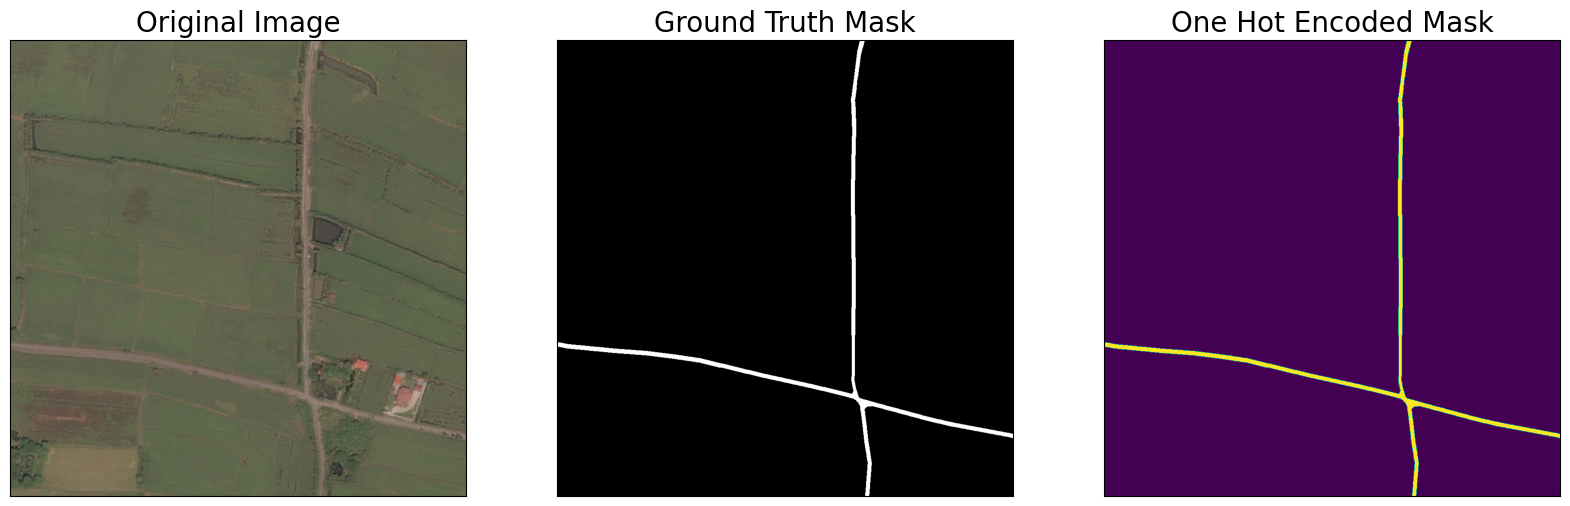

In [ ]:
dataset = RoadsDataset(train_df, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[2]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

### Defining Augmentations 🙃

In [ ]:
def get_training_augmentation():
    train_transform = [
        album.HorizontalFlip(p=0.5),
        album.VerticalFlip(p=0.5),
    ]
    return album.Compose(train_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform
    Args:
        preprocessing_fn (callable): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))

    return album.Compose(_transform)

#### Visualize Augmented Images & Masks

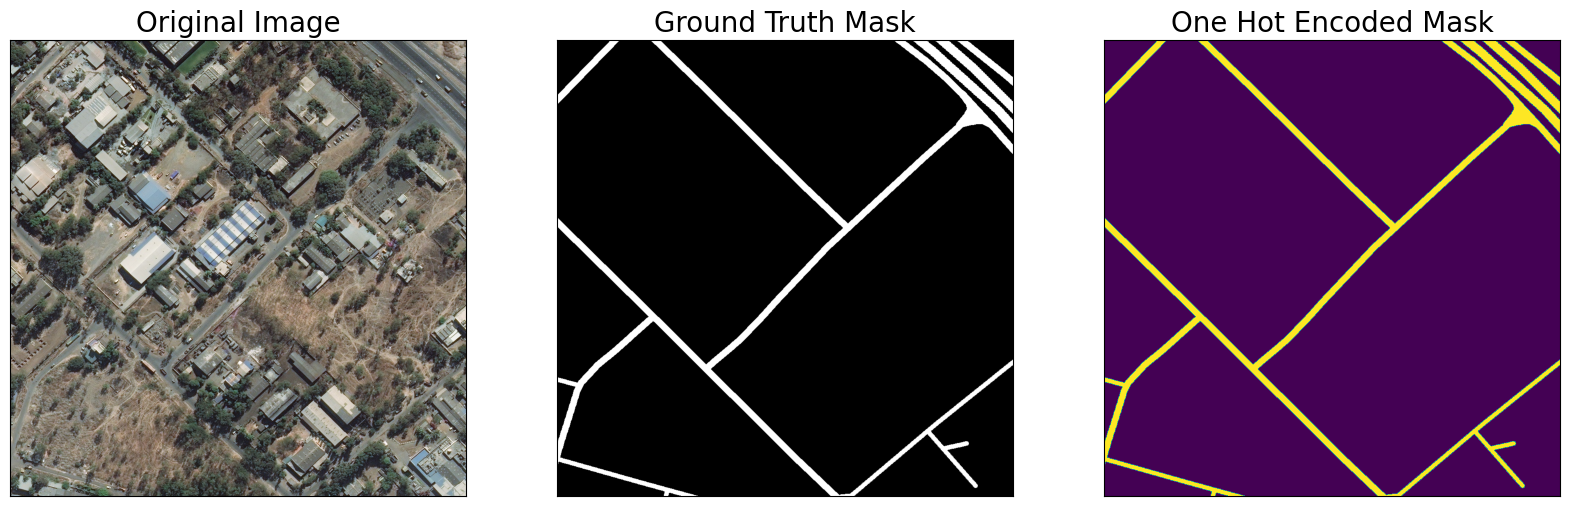

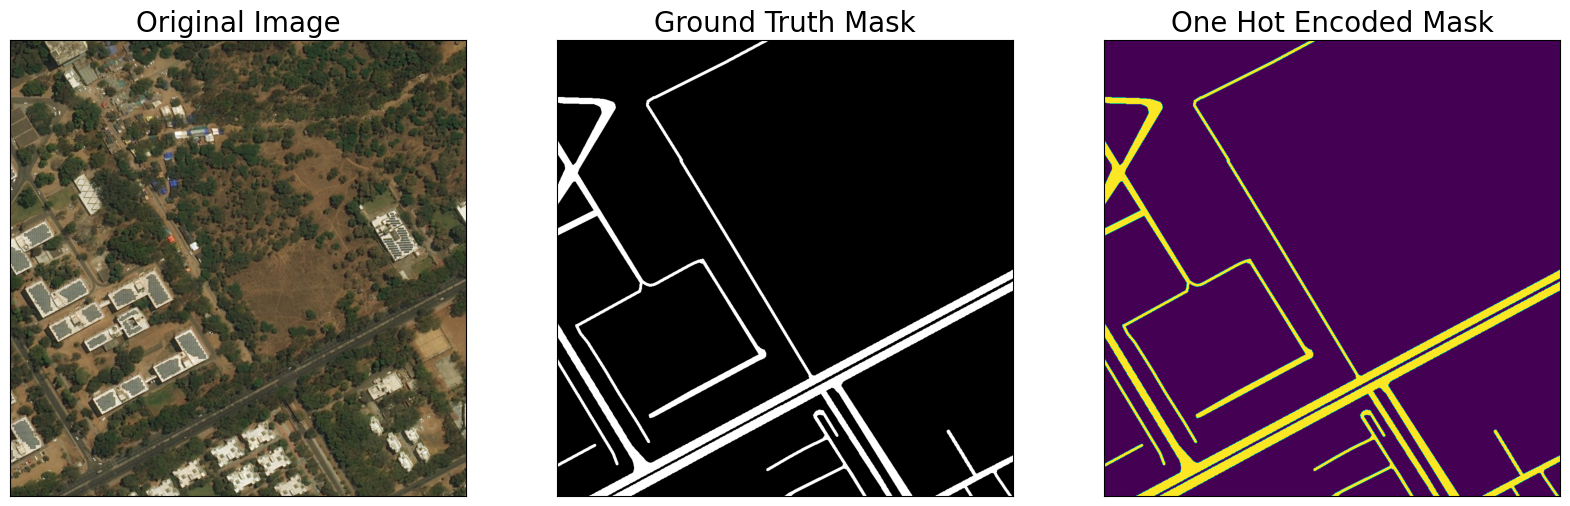

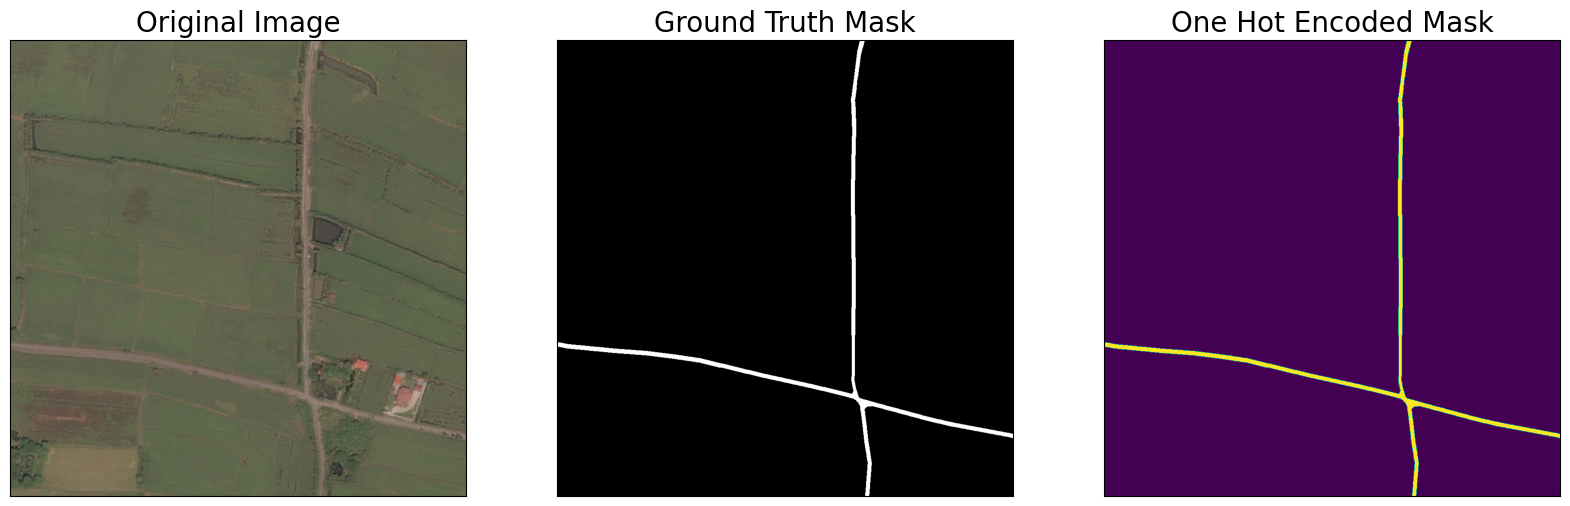

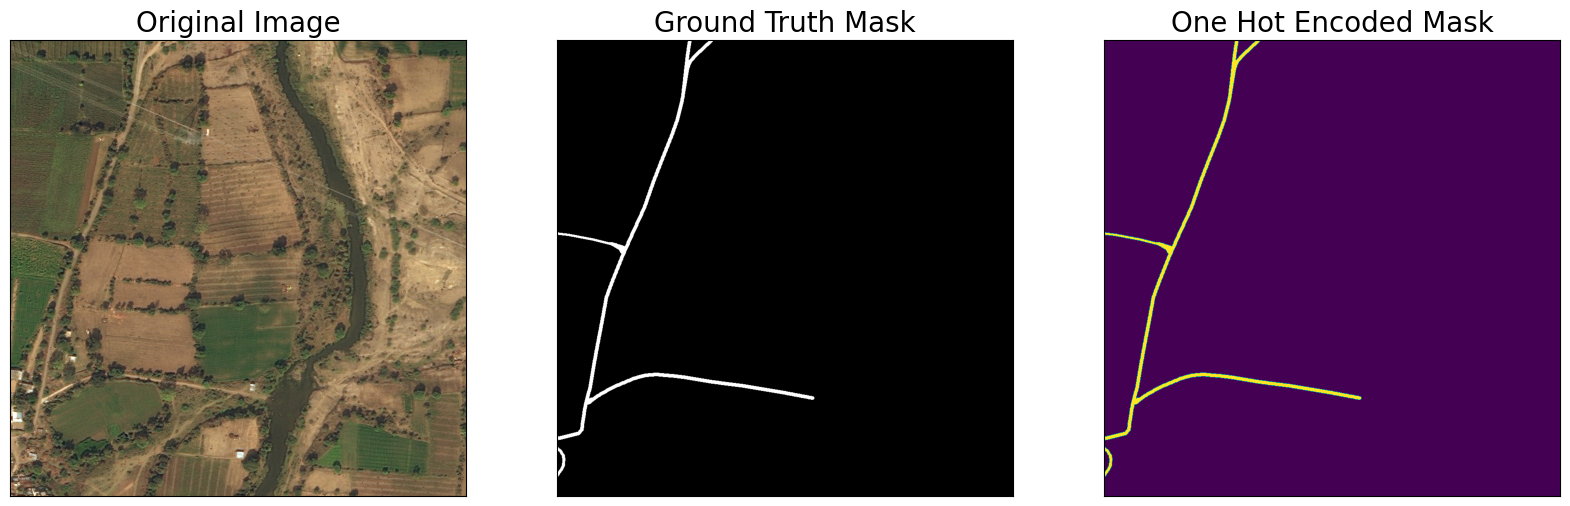

In [ ]:
augmented_dataset = RoadsDataset(
    train_df,
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)
image_paths = train_df['sat_image_path'].tolist()
# Different augmentations on image/mask pairs
for idx in range(4):
      image, mask = augmented_dataset[idx]

      visualize(
          original_image = image,
          ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
          one_hot_encoded_mask = reverse_one_hot(mask)
      )



### Model Definition

In [ ]:
ENCODER = 'vgg11'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to /root/.cache/torch/hub/checkpoints/vgg11-bbd30ac9.pth
100%|██████████| 507M/507M [00:02<00:00, 178MB/s]


#### Get Train / Val DataLoaders

In [ ]:
# Get train and val dataset instances
train_dataset = RoadsDataset(
    train_df,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = RoadsDataset(
    valid_df,
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=4)

In [ ]:
len(train_dataset)

2400

#### Set Hyperparams

In [ ]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 20

CHECKPOINT_PATH = '/content/drive/MyDrive/road_unet11_original.pth'

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.00008),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
if os.path.exists(CHECKPOINT_PATH):
    model = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
    print('Loaded pre-trained DeepLabV3+ model!')

Loaded pre-trained DeepLabV3+ model!


In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

### Training UNet11

In [ ]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, CHECKPOINT_PATH)
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 150/150 [01:35<00:00,  1.57it/s, dice_loss - 0.08831, iou_score - 0.945]
Model saved!

Epoch: 1
valid: 100%|██████████| 150/150 [01:34<00:00,  1.59it/s, dice_loss - 0.04129, iou_score - 0.9511]
Model saved!

Epoch: 2
valid: 100%|██████████| 150/150 [01:34<00:00,  1.58it/s, dice_loss - 0.03115, iou_score - 0.9533]
Model saved!

Epoch: 3
valid: 100%|██████████| 150/150 [01:33<00:00,  1.60it/s, dice_loss - 0.027, iou_score - 0.9545]
Model saved!

Epoch: 4
valid: 100%|██████████| 150/150 [01:36<00:00,  1.56it/s, dice_loss - 0.02487, iou_score - 0.956]
Model saved!

Epoch: 5
valid: 100%|██████████| 150/150 [01:35<00:00,  1.57it/s, dice_loss - 0.02421, iou_score - 0.956]

Epoch: 6
valid: 100%|██████████| 150/150 [01:34<00:00,  1.59it/s, dice_loss - 0.0225, iou_score - 0.958]
Model saved!

Epoch: 7
train:  50%|████▉     | 297/600 [06:30<06:29,  1.28s/it, dice_loss - 0.02036, iou_score - 0.962] 

### Prediction on Test Data

In [ ]:
# load best saved model checkpoint from the current run
if os.path.exists(CHECKPOINT_PATH):
    best_model = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
    print('Loaded DeepLabV3+ model from this run.')



Loaded DeepLabV3+ model from this run.


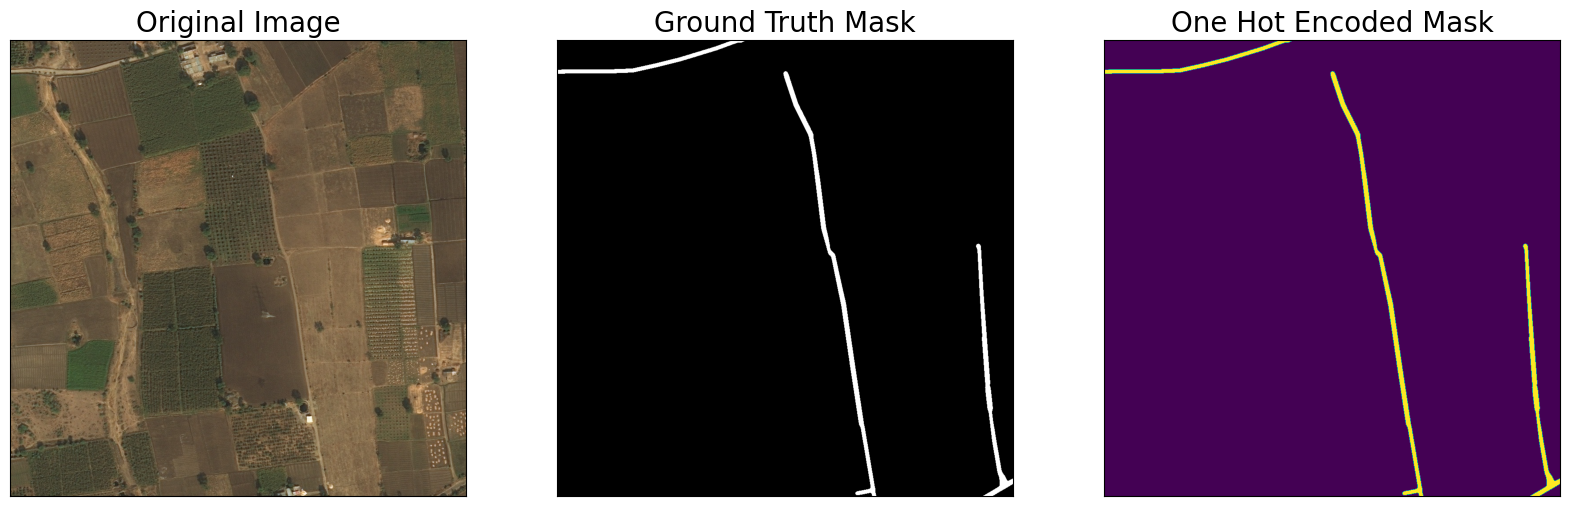

In [ ]:
# create test dataloader to be used with DeepLabV3+ model (with preprocessing operation: to_tensor(...))
test_dataset = RoadsDataset(
    valid_df,
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
    isTest=True
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing augmentations & transformations)
test_dataset_vis = RoadsDataset(
    valid_df,
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)


In [ ]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [ ]:
for idx in range(len(test_dataset)):

    image, gt_mask = test_dataset[idx]
    image_vis = test_dataset_vis[idx][0].astype('uint8')
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to foreground
    pred_road_heatmap = pred_mask[:,:,select_classes.index('road')]
    pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values)
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])

    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        pred_road_heatmap = pred_road_heatmap
    )

### Model Evaluation on Test Dataset

In [ ]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid:   0%|          | 2/600 [00:35<2:56:58, 17.76s/it, dice_loss - 0.02386, iou_score - 0.9559]


KeyboardInterrupt: ignored

### Plot Dice Loss & IoU Metric for Train vs. Val

In [ ]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()